In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [96]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [97]:
#Importing data from file

def import_data():
    df = pd.read_excel('dat/anuro_ppf.xls', sheet_name='PPF_margins', usecols='A:J')

    pdur = df['PDUR'].values
    ppau = df['PPAU'].values
    phonotaxis = df['rXY'].values

    dur_max = 20  # ms
    dur_step = 0.5  # ms
    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T
    # points = np.array([pdur, ppau]).T


    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))
    
    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    # print(np.any(np.isnan(new_points)))
    
    ppf /= np.max(ppf)
    
    return ppf


In [98]:
#defining some global variables that are constant and used throughout the code

dur_max = 20  # ms
dur_step = 0.5  # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data()
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

In [99]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [116]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [101]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [102]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [103]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [104]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [105]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

In [106]:
#setting initial values. and printing the start point of the minimize function present below
cfg = [120, 7, 0, 0, 0.04, 0.02]
y = sig_diff(cfg)
print(y)


0.1353713008349576


In [107]:
#bounds of each parameter

b_fr = (0, 300)
b_sigma = (1, 101)
b_phi = (0, 2)
b_w = (-0.1, 0.1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


In [108]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [114]:
#Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. , 'maxfev':1500  'options' : {"disp": True},  
result = spo.basinhopping(sig_diff, cfg, niter = 10, minimizer_kwargs={'bounds' : bnds, 'method' : 'L-BFGS-B'})

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.11608815972599193
                          x: [ 1.154e+02  1.000e+01  0.000e+00 -7.285e-02
                               1.561e-01  1.108e+00]
                        nit: 10
      minimization_failures: 1
                       nfev: 2891
                       njev: 413
 lowest_optimization_result:  message: ABNORMAL_TERMINATION_IN_LNSRCH
                              success: False
                               status: 2
                                  fun: 0.11608815972599193
                                    x: [ 1.154e+02  1.000e+01  0.000e+00
                                        -7.285e-02  1.561e-01  1.108e+00]
                                  nit: 18
                                  jac: [ 1.300e-04  6.036e+03  0.000e+00
                                         0.000e+00  2.771e-04  1.076e-04]
        

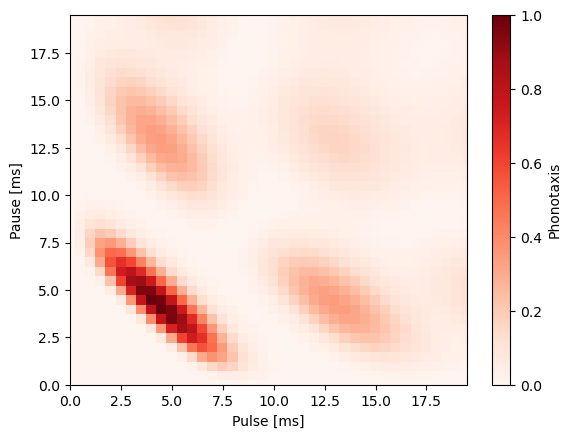

In [115]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xe = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xe[1])